# GRU + Attention

## Overview

**This notebook extends the GRU Classifier model (movie watching) described in the [paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008943)  by adding an `Attention Layer`**

Attention used here was first presented by Dzmitry Bahdanau, et al. in their paper [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473).


---
## Data

**Data provided is already preprocessed but needs to be converted in model usabale format**

In [1]:
import torch
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
with open('Data/HCP_movie_watching.pkl','rb') as f:
    TS = pickle.load(f)
print(TS.keys())

dict_keys(['testretest', 'twomen', 'bridgeville', 'pockets', 'overcome', 'inception', 'socialnet', 'oceans', 'flower', 'hotel', 'garden', 'dreary', 'homealone', 'brokovich', 'starwars'])


### Dataset organization
`TS` is a dictionary with movie names as keys

Value against each key is a numpy array of dimensions `[#participants, #time points, #ROIs]`

Note that the testretest movie appears on all 4 runs for a participant, therefore the value has dimensions `[#runs, #participants, #time points, #ROIs]`

In [3]:
rel = {}
l = 0
seq_length = 0
time_changes = []
for movie_name, ts in TS.items():
    rel[movie_name] = l
    l += 1
    seq_length = max(seq_length, ts.shape[-2])
    time_changes.append(ts.shape[-2])
    print(movie_name, ts.shape)
time_changes = np.array(time_changes)
time = [i for i in range(1,seq_length+1)]

testretest (4, 176, 84, 300)
twomen (176, 245, 300)
bridgeville (176, 222, 300)
pockets (176, 189, 300)
overcome (176, 65, 300)
inception (176, 227, 300)
socialnet (176, 260, 300)
oceans (176, 250, 300)
flower (176, 181, 300)
hotel (176, 186, 300)
garden (176, 205, 300)
dreary (176, 143, 300)
homealone (176, 233, 300)
brokovich (176, 231, 300)
starwars (176, 256, 300)


### Padding sequences

To deal with varying `time points`. For data with `time points < seq_length` , I have paded them with -100.. I have used the `seq_length = 260` (maximum of the time_point).

**Final `features` array is a 2D array, with shape = `(260,300)`.**

The following block shows above mentioned discussion

In [ ]:
train_feature = []
test_feature  = []
train_target  = []
test_target   = []

for movie_name, ts in TS.items():
    pep = 0
    if movie_name != "testretest":
        for i in ts:
            pep += 1
            if (pep <= 100):
                if i.shape[0]>seq_length:
                    k = i[:seq_length][:]
                    train_feature.append(k)
                    train_target.append(rel[movie_name])
                    
                    k = i[i.shape[0]-seq_length:][:]
                    train_feature.append(k)
                    train_target.append(rel[movie_name])
                
                elif i.shape[0]<seq_length:
                    k = [[-100]*300]*seq_length
                    k[seq_length-i.shape[0]:] = i
                    train_feature.append(k)
                    k = [[rel[movie_name]] for _ in range(i.shape[0])] + [[-100] for _ in range(seq_length-i.shape[0])]
                    train_target.append(k)
                else:
                    train_feature.append(i)
                    train_target.append([[rel[movie_name]] for _ in range(seq_length)])

            else:
                if i.shape[0]>seq_length:
                    k = i[:seq_length][:]
                    test_feature.append(k)
                    test_target.append(rel[movie_name])
                   
                    k = i[i.shape[0]-seq_length:][:]
                    test_feature.append(k)
                    test_target.append(rel[movie_name])
                
                elif i.shape[0]<seq_length:
                    k = [[-100]*300]*seq_length
                    k[seq_length-i.shape[0]:] = i
                    test_feature.append(k)
                    k = [[rel[movie_name]] for _ in range(i.shape[0])] + [[-100] for _ in range(seq_length-i.shape[0])]
                    test_target.append(k)
                else:
                    test_feature.append(i)
                    test_target.append([[rel[movie_name]] for _ in range(seq_length)])
        print(pep)
    else:
        for jj in ts:
            pep = 0
            for i in jj:
                pep += 1
                if (pep <= 106):
                    if i.shape[0]>seq_length:
                        k = i[:seq_length][:]
                        train_feature.append(k)
                        train_target.append(rel[movie_name])

                        k = i[i.shape[0]-seq_length:][:]
                        train_feature.append(k)
                        train_target.append(rel[movie_name])

                    elif i.shape[0]<seq_length:
                        k = [[-100]*300]*seq_length
                        k[seq_length-i.shape[0]:] = i
                        train_feature.append(k)
                        k = [[rel[movie_name]] for _ in range(i.shape[0])] + [[-100] for _ in range(seq_length-i.shape[0])]
                        train_target.append(k)
                    else:
                        train_feature.append(i)
                        train_target.append([[rel[movie_name]] for _ in range(seq_length)])

                else:
                    if i.shape[0]>seq_length:
                        k = i[:seq_length][:]
                        test_feature.append(k)
                        test_target.append(rel[movie_name])

                        k = i[i.shape[0]-seq_length:][:]
                        test_feature.append(k)
                        test_target.append(rel[movie_name])

                    elif i.shape[0]<seq_length:
                        k = [[-100]*300]*seq_length
                        k[seq_length-i.shape[0]:] = i
                        test_feature.append(k)
                        k = [[rel[movie_name]] for _ in range(i.shape[0])] + [[-100] for _ in range(seq_length-i.shape[0])]
                        test_target.append(k)
                    else:
                        test_feature.append(i)
                        test_target.append([[rel[movie_name]]*15 for _ in range(seq_length)])
            print(pep)

### Training, Validation, Test

With the data in required shape, The following shows the split into training, validation, and test sets.

In [5]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.from_numpy(np.array(train_feature)).float(),torch.from_numpy(np.array(train_target)).float())
test_data  = TensorDataset(torch.from_numpy(np.array(test_feature)).float(),torch.from_numpy(np.array(test_target)).float())

In [6]:
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 32
valid_data  = 0.246
t_train     = len(train_data)
data_no     = list(range(t_train))
np.random.shuffle(data_no)
split_no    = int(valid_data*t_train)
train,valid = data_no[split_no:],data_no[:split_no]

train_sampler = SubsetRandomSampler(train)
valid_sampler = SubsetRandomSampler(valid)

train_loader  = DataLoader(train_data,batch_size=batch_size,sampler=train_sampler)#drop_last=True)
valid_loader  = DataLoader(train_data,sampler=valid_sampler,batch_size=batch_size)#drop_last=True)
test_loader   = DataLoader(test_data, batch_size=batch_size,shuffle = True)

In [7]:
iter(train_loader).next()[0].shape

torch.Size([32, 260, 300])

In [8]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cuda')

## Models

### Implementing the `Attention(Bahdanau)` Model

Following figures shows the steps involved in: Blue are the parameters

<img src="attn_enc.png">

In [9]:
class Attention(nn.Module):
    
    def __init__(self, hidden_dim):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        self.W = nn.Linear(2*hidden_dim, hidden_dim, bias=False) 
        self.V = nn.Parameter(torch.rand(hidden_dim))
        self.softmax = nn.Softmax(dim = 1)
    
    def forward(self, x, hj):
        ''' 
            PARAMS:           
                hj: prev hidden_state:    [b, n_layers, hidden_dim]                
                x : gru layer output: [b, seq_len, hidden_dim] 
            
            RETURN:
                att_weights:    [b, src_seq_len] 
        '''
        
        hj = hj.permute(1, 0, 2)
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        hj = hj[:, -1, :].unsqueeze(1).repeat(1, seq_length, 1)        #[b, seq_len, hidden_dim]
        
        tanh_W_s_h = torch.tanh(self.W(torch.cat((x, hj), dim=2)))  #[b, seq_len, hidden_dim]
        tanh_W_s_h = tanh_W_s_h.permute(0, 2, 1)       #[b, hidden_dim, seq_len]
        
        V = self.V.repeat(batch_size, 1).unsqueeze(1)  #[b, 1, hidden_dim]
        e = torch.bmm(V, tanh_W_s_h).squeeze(1)        #[b, seq_len]
        
        att_weights = self.softmax(e)              #[b, seq_len]
        
        return att_weights

### `GRU Classifier` Model as described in the [paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008943)
<img src="gru.png">

In [10]:
class GRU_RNN(nn.Module):

    def __init__(self, input_dim, output_dim,hidden_dim,n_layers,att=True,drop_prob=0.0):
        super(GRU_RNN, self).__init__()

        self.output_dim = output_dim
        self.n_layers   = n_layers
        self.hidden_dim = hidden_dim
        self.att        = att
        
        self.gru       = nn.GRU(input_dim,hidden_dim,num_layers=n_layers,dropout=0.0,batch_first=True)

        
        self.linear    = nn.Linear(hidden_dim,output_dim)
        if att:
            self.attention = Attention(hidden_dim) 
            self.linear    = nn.Linear(2*hidden_dim,output_dim)
        self.dropout   = nn.Dropout(0.3)
        self.func      = nn.Softmax(dim=-1)

    def forward(self, input_x, hj, prev_x):
        xi,hi = self.gru(input_x,hj) # xi: [b,seq_len,hidden_dim] | hi: [n_layers,b,hidden_dim]

        if self.att:
            att_weights = self.attention(xi,hj).unsqueeze(1)
            
            weighted_sum = torch.bmm(att_weights,prev_x).squeeze(1)
            x = torch.cat((weighted_sum,xi[:,-1,:]), dim=1).unsqueeze(2) # [b,hidden*2,1]
            x = x.repeat(1,1,seq_length)
            x = x.permute(0,2,1)
            x = self.linear(x)
        else:
            #x = self.dropout(x)
            x = self.linear(xi)

        return x,hi,xi
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

## Train & Test Function

In [11]:
def train(epochs,train_loader,net,valid_loader,optimizer,criterion,name):
    clip = 3 # gradient clipping

    net.to(device)
    net.train()
    valid_loss_min = np.Inf 
    
    valid_losses = []
    train_losses = []
    
    for e in range(epochs):
        h = net.init_hidden(batch_size)
        prev_x = torch.zeros(batch_size,seq_length,hidden_dim).to(device)
        nn.init.kaiming_uniform_(prev_x)
        train_loss = []
        valid_loss = []
        
        for inputs, labels in train_loader:
            #torch.autograd.set_detect_anomaly(True)
            inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
            h = h.data
            net.zero_grad()
            output, h, prev_x = net(inputs, h.detach(), prev_x.detach())
            
            loss = criterion(output.permute(0,2,1), labels.squeeze())
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()
            train_loss.append(loss.item())
        
        val_h = net.init_hidden(batch_size)
        val_prev_x = torch.zeros(batch_size,seq_length,hidden_dim).to(device)
        nn.init.kaiming_uniform_(val_prev_x)
        val_losses = []
        net.eval()

        for inputs, labels in valid_loader:
            val_h = val_h.data
            inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
            output, val_h, val_prev_x = net(inputs, val_h,val_prev_x)
            val_loss = criterion(output.permute(0,2,1),labels.squeeze())
            val_losses.append(val_loss.item())
        if np.mean(val_losses) <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, np.mean(val_losses)))
            best_epoch = e
            torch.save(net.state_dict(), f'{name}.pt')
            valid_loss_min = np.mean(val_losses)

        net.train()
        valid_losses.append(np.mean(val_losses))
        train_losses.append(np.mean(train_loss))
        print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(e+1,epochs,np.mean(train_loss),np.mean(val_losses)))
    
    return train_losses,valid_losses,best_epoch

In [12]:
def calc(pred,lab):
    pred_2 = torch.where(lab!=-100,pred,100)
    al = np.array((pred_2-lab).to('cpu'))
    z = al.shape[0] - np.sum(al==200,axis=0)
    y = al.shape[0] - np.count_nonzero(al, axis=0)
    return y/z


def test(test_loader,net):
    net.to(device)
    net.eval()
    h = net.init_hidden(batch_size)
    prev_x = torch.zeros(batch_size,seq_length,hidden_dim).to(device)
    nn.init.kaiming_uniform_(prev_x)
    T_pred = None
    T_lab = None
    for inputs, labels in test_loader:
        h = h.data
        inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
        output, h,prev_x = net(inputs, h,prev_x)
        pred = torch.round(output.squeeze()) 
        top_value, top_index = torch.max(pred,2,keepdim=True)
        
        if T_pred == None:
            T_pred = top_index.squeeze()
            T_lab = labels.squeeze()
        else:
            T_pred = torch.cat((T_pred,top_index.squeeze()),0)
            T_lab = torch.cat((T_lab,labels.squeeze()),0)
    return T_pred,T_lab

## Training with Attention Layer

In [13]:
epochs     = 45
input_dim  = 300
hidden_dim = 32
output_dim = 15
n_layers   = 1
lr         = 0.002

In [14]:
model     = GRU_RNN(input_dim, output_dim, hidden_dim, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
print(model)

GRU_RNN(
  (gru): GRU(300, 32, batch_first=True)
  (linear): Linear(in_features=64, out_features=15, bias=True)
  (attention): Attention(
    (W): Linear(in_features=64, out_features=32, bias=False)
    (softmax): Softmax(dim=1)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (func): Softmax(dim=-1)
)


In [15]:
train_losses,valid_losses,best_epoch = train(epochs,train_loader,model,valid_loader,optimizer,criterion,"Att")

Validation loss decreased (inf --> 2.006807).  Saving model ...
Epoch: 1/45 	Training Loss: 2.309377 	Validation Loss: 2.006807
Validation loss decreased (2.006807 --> 1.490849).  Saving model ...
Epoch: 2/45 	Training Loss: 1.616253 	Validation Loss: 1.490849
Validation loss decreased (1.490849 --> 1.126686).  Saving model ...
Epoch: 3/45 	Training Loss: 1.104379 	Validation Loss: 1.126686
Validation loss decreased (1.126686 --> 0.925915).  Saving model ...
Epoch: 4/45 	Training Loss: 0.756070 	Validation Loss: 0.925915
Validation loss decreased (0.925915 --> 0.787860).  Saving model ...
Epoch: 5/45 	Training Loss: 0.523056 	Validation Loss: 0.787860
Validation loss decreased (0.787860 --> 0.716097).  Saving model ...
Epoch: 6/45 	Training Loss: 0.369060 	Validation Loss: 0.716097
Validation loss decreased (0.716097 --> 0.694975).  Saving model ...
Epoch: 7/45 	Training Loss: 0.265166 	Validation Loss: 0.694975
Validation loss decreased (0.694975 --> 0.637512).  Saving model ...
Epoch

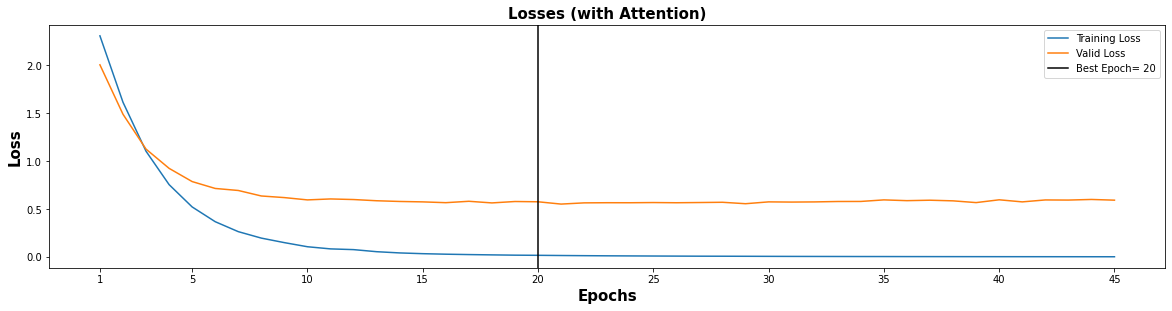

In [16]:
x     = [i for i in range(1,epochs+1)]
xi    = [i for i in range(0,epochs+5,5)]
xi[0] = 1
f, axis = plt.subplots(1,1)
f.set_figwidth(20)
f.set_figheight(5)
plt.subplots_adjust(top=0.8, wspace=0.2,hspace=0.3)

axis.plot(x,train_losses)
axis.plot(x,valid_losses)
axis.axvline(best_epoch, color='black')
axis.set_xticks(xi)
axis.set_xlabel("Epochs",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis.set_ylabel("Loss",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis.set_title("Losses (with Attention)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis.legend(["Training Loss","Valid Loss",f"Best Epoch= {best_epoch}"])

In [17]:
model = GRU_RNN(input_dim, output_dim, hidden_dim, n_layers)
model.load_state_dict(torch.load('Att.pt'))

<All keys matched successfully>

In [18]:
pred,lab = test(test_loader,model)
time_point_acc = calc(pred,lab)

## Training without Attention Layer

In [19]:
epochs     = 45
input_dim  = 300
hidden_dim = 32
output_dim = 15
n_layers   = 1
lr         = 0.006

In [20]:
model2     = GRU_RNN(input_dim, output_dim, hidden_dim, n_layers,att=False)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=lr)
criterion2 = nn.CrossEntropyLoss(ignore_index=-100)
print(model2)

GRU_RNN(
  (gru): GRU(300, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=15, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (func): Softmax(dim=-1)
)


In [21]:
train_losses_1,valid_losses_1,best_epoch_1 = train(epochs,train_loader,model2,valid_loader,optimizer2,criterion2,"GRU")

Validation loss decreased (inf --> 2.514711).  Saving model ...
Epoch: 1/45 	Training Loss: 2.642447 	Validation Loss: 2.514711
Validation loss decreased (2.514711 --> 2.477094).  Saving model ...
Epoch: 2/45 	Training Loss: 2.524199 	Validation Loss: 2.477094
Validation loss decreased (2.477094 --> 2.256657).  Saving model ...
Epoch: 3/45 	Training Loss: 2.380000 	Validation Loss: 2.256657
Validation loss decreased (2.256657 --> 2.150577).  Saving model ...
Epoch: 4/45 	Training Loss: 2.110968 	Validation Loss: 2.150577
Validation loss decreased (2.150577 --> 2.046364).  Saving model ...
Epoch: 5/45 	Training Loss: 1.985462 	Validation Loss: 2.046364
Validation loss decreased (2.046364 --> 1.885488).  Saving model ...
Epoch: 6/45 	Training Loss: 1.877682 	Validation Loss: 1.885488
Epoch: 7/45 	Training Loss: 1.879785 	Validation Loss: 1.959972
Validation loss decreased (1.885488 --> 1.841028).  Saving model ...
Epoch: 8/45 	Training Loss: 1.746551 	Validation Loss: 1.841028
Epoch: 9/4

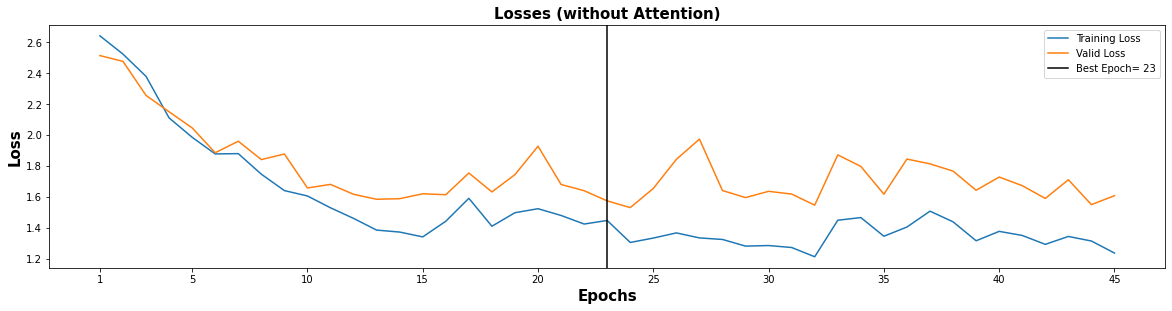

In [22]:
x     = [i for i in range(1,epochs+1)]
xi    = [i for i in range(0,epochs+5,5)]
xi[0] = 1
f, axis = plt.subplots(1,1)
f.set_figwidth(20)
f.set_figheight(5)
plt.subplots_adjust(top=0.8, wspace=0.2,hspace=0.3)

axis.plot(x,train_losses_1)
axis.plot(x,valid_losses_1)
axis.axvline(best_epoch_1, color='black')
axis.set_xticks(xi)
axis.set_xlabel("Epochs",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis.set_ylabel("Loss",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis.set_title("Losses (without Attention)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis.legend(["Training Loss","Valid Loss",f"Best Epoch= {best_epoch_1}"]);

In [23]:
model2 = GRU_RNN(input_dim, output_dim, hidden_dim, n_layers,att=False)
model2.load_state_dict(torch.load('GRU.pt'))

<All keys matched successfully>

In [24]:
pred1,lab = test(test_loader,model2)
time_point_acc1 = calc(pred1,lab)

## Testing

### Accuracy with Attention Layer

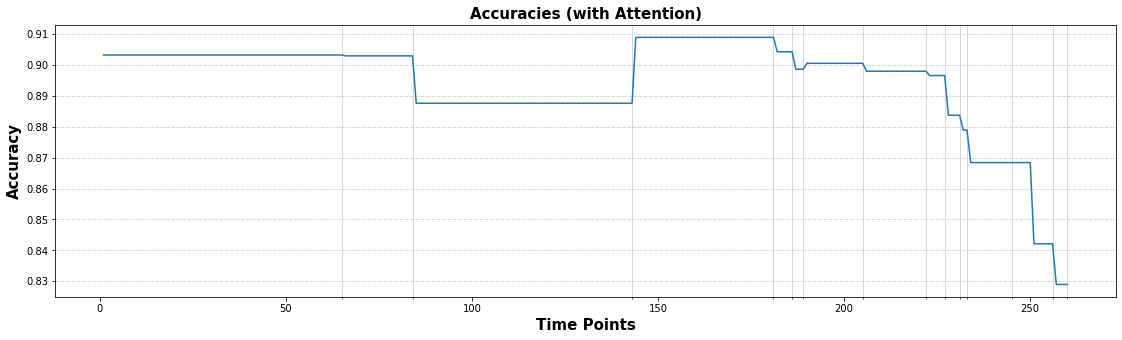

In [25]:
f, ax = plt.subplots(1,1)
f.set_figwidth(19)
f.set_figheight(5)
ax.plot(time,time_point_acc)
ax.set_xticks(time_changes, minor=True)
ax.yaxis.grid(True,linestyle='-.', linewidth=0.5, which='both')
ax.xaxis.grid(True,linestyle='-', linewidth=0.5, which='minor')
ax.set_xlabel("Time Points",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
ax.set_ylabel("Accuracy",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
ax.set_title("Accuracies (with Attention)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center');

### Accuracy without Attention Layer

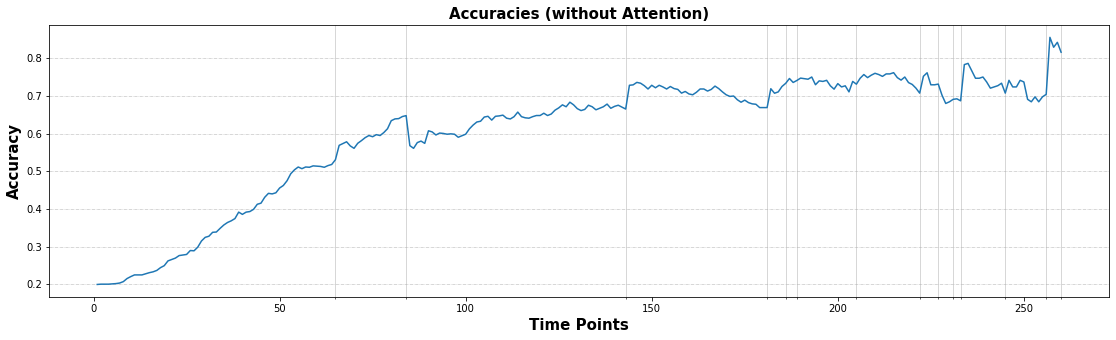

In [26]:
f, ax = plt.subplots(1,1)
f.set_figwidth(19)
f.set_figheight(5)
ax.plot(time,time_point_acc1)
ax.set_xticks(time_changes, minor=True)
ax.yaxis.grid(True,linestyle='-.', linewidth=0.5, which='both')
ax.xaxis.grid(True,linestyle='-', linewidth=0.5, which='minor')
ax.set_xlabel("Time Points",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
ax.set_ylabel("Accuracy",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
ax.set_title("Accuracies (without Attention)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center');

## Comparison

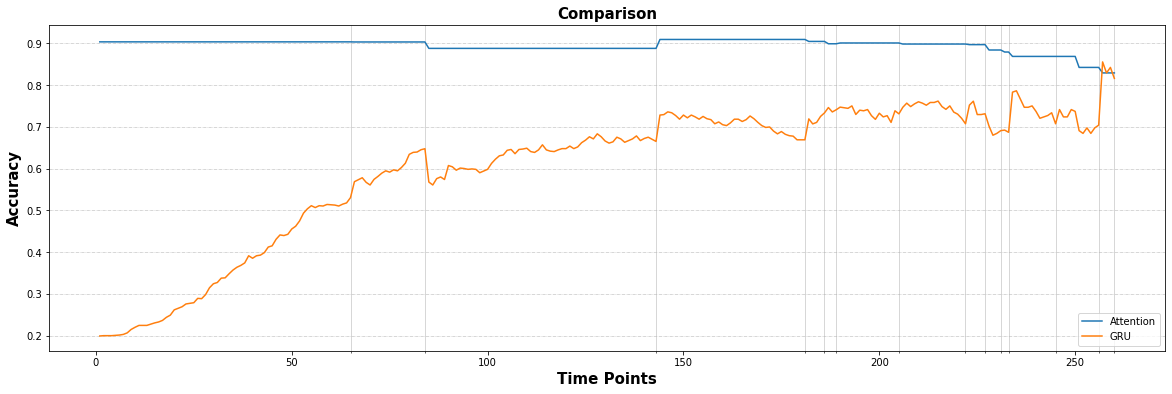

In [28]:
f, ax = plt.subplots(1,1)
f.set_figwidth(20)
f.set_figheight(6)
ax.plot(time,time_point_acc)
ax.plot(time,time_point_acc1)
ax.set_xticks(time_changes, minor=True)
ax.yaxis.grid(True,linestyle='-.', linewidth=0.5, which='both')
ax.xaxis.grid(True,linestyle='-', linewidth=0.5, which='minor')
ax.legend(["Attention","GRU"])
ax.set_xlabel("Time Points",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
ax.set_ylabel("Accuracy",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
ax.set_title("Comparison",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center');

In [30]:
with open('acc.npy', 'wb') as f:
    np.save(f, time_point_acc)
    np.save(f, time_point_acc1)

## Conclusion

Adding an Attention Layer has increased the model accuracy as expected.
The model furthur can be extended/improved by using other methods such as in: [transformers](https://akshatyadav0.github.io/P_Lab_Works/Transformers.html) notebook 